In [1]:
__author__ = 'Knut Olsen <knut.olsen@noirlab.edu>, Alice Jacques <alice.jacques@noirlab.edu>, Astro Data Lab Team <datalab@noirlab.edu>'
__version__ = '20240606' # yyyymmdd
__datasets__ = ['nsc_dr2', 'gaia_dr3']
__keywords__ = ['Pal5', 'joint query', 'plot:cmd', 'plot:histogram', 'plot:quiver', 'convolution', 'proper motions']

# The Tidal Tails of Palomar 5

*Knut Olsen, Alice Jacques, and the Astro Data Lab Team*

### Table of contents
* [Goals & Summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#login)
* [Joint query of NSC DR2 and Gaia DR3](#photometry)
* [Isolating Palomar 5](#isolate)
* [Spatial filtering](#filter)
* [Exploring the proper motions](#propermotions)

<a class="anchor" id="goals"></a>
# Goals
* Learn how to use a pre-computed crossmatch table to do a joint query on two datasets, NSC DR2 and Gaia DR3
* Demonstrate application of a filter in color-magnitude space to isolate the Palomar 5 stellar population
* Use a spatial convolution filter to reveal and enhance the tidal tails of Palomar 5
* Apply proper motion filters to further enhance the tidal tails


# Summary

In this notebook, we demonstrate the identification of the tidal tails of the globular cluster Palomar 5 in the NSC DR2 catalog, as well as a join against Gaia DR3 to explore the proper motion of the cluster and its tails. We issue a query around the position of the globular cluster and retrieve all data from NSC DR2 within an area of sky, as well as information from Gaia DR3 for any objects that have matches. 

This notebook makes use of a pre-computed crossmatch table at Astro Data Lab. For more information on our pre-computed crossmatch tables, see our Jupyter notebook on [How-To Use the pre-crossmatched tables at Astro Data Lab](https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/CrossmatchTables/How_to_use_pre_crossmatched_tables.ipynb) as well as our [Examples using the pre-crossmatched tables at Astro Data Lab](https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/CrossmatchTables/Examples_using_pre_crossmatched_tables.ipynb).

### Background

[Odenkirchen M. et al., 2001, ApJ, 548, L165](https://ui.adsabs.harvard.edu/abs/2001ApJ...548L.165O/abstract) found extended tidal tails around the globular cluster Palomar 5 using data from SDSS.  The tails indicate that the cluster is in the process of evaporation.  They are useful tracers of the Milky Way's gravitational potential, and are potential probes of discrete dark matter subhalos in the Milky Way.

### Data retrieval

We will use catalog data found in three tables: the NSC DR2 object table, the Gaia DR3-NSC DR2 crossmatch table, and the Gaia DR3 source table.

### Detection

In order to pick out the tidal tails, we'll filter the NSC DR2 catalog results to isolate the Pal 5 sequence, and then run a differential convolution filter of the spatial distribution to bring out the tails.  We'll then explore the proper motions of the cluster and tails using the Gaia DR3 data.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="import"></a>
# Imports and initialization

In [2]:
# std lib
from getpass import getpass

# 3rd party
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import utils, io, convolution, wcs
from astropy.coordinates import name_resolve
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert

In [3]:
## Setting up plots
settings = {
    'font.size':16,
    'axes.linewidth':1.0,
    'xtick.major.size':3.0,
    'xtick.minor.size':1.0,
    'xtick.major.width':2.0,
    'xtick.minor.width':0.5,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':3.0,
    'ytick.minor.size':1.0,
    'ytick.major.width':2.0,
    'ytick.minor.width':0.5,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True
}

plt.rcParams.update(**settings)

<a class="anchor" id="login"></a>
# Log in
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [4]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
#ac.whoAmI()

<a class="anchor" id="photometry"></a>
# Coordinates and photometry and proper motion data around Pal 5
We resolve the positions of Pal 5 and query the database for stars around it.  We'll describe the login in a bit of detail below.

In [5]:
try:
    c = name_resolve.get_icrs_coordinates('Palomar 5')
except:
    coord_str="15 16 05.30 -00 06 41.0"
    c=SkyCoord(coord_str,unit=(u.hourangle, u.deg))

### Query logic

The goal of the query is to retrieve all stars from NSC DR2 within a significant radius of Pal 5, in this case 2 degrees.  We also want to retrieve measurements from Gaia DR3 when it's available.  This kind of query is referred to as a LEFT JOIN: we want to get *all* of the data from one table (`nsc_dr2.object`) as well as all of the data that intersects (through a cross-match) with another table (`gaia_dr3.gaia_source`).

Rather than do the positional cross-match on the fly, we'll make use of a pre-computed crossmatch table (`gaia_dr3.x1p5__gaia_source__nsc_dr2__object`) which we need to INNER JOIN against the Gaia source table (`gaia_dr3.gaia_source`) in order to access the Gaia measurements.

The logic of the query then goes like this:
- JOIN the crossmatch table against the Gaia source table, subject to the spatial constraint of being within 2 degrees of Pal 5, and materialize this table in the query (we'll call it `gt`)
- Perform the LEFT JOIN of nsc_dr2 with this materialized table, and constrain nsc_dr2 to also only contain sources within 2 degrees of Pal 5
- Return rows from both nsc_dr2 and gaia_dr3.  If there are objects in nsc_dr2 that have no gaia_dr3 crossmatch, the Gaia columns for those objects will be null.

In [6]:
radius = 2.0
query2 = """
SELECT 
    n.id, n.ra, n.dec, n.pmra, n.pmdec, n.pmraerr, n.pmdecerr, n.mjd, n.umag, n.uerr,
    n.gmag, n.gerr, n.rmag, n.rerr, n.imag, n.ierr, n.zmag, n.zerr, gt.*
FROM 
    nsc_dr2.object AS n
LEFT JOIN (
    SELECT 
        x.id1 as gaia_id, x.id2 as nsc_id, x.ra1 as gaia_ra, x.dec1 as gaia_dec, x.distance as dist,
        g.phot_g_mean_mag as gaia_G, g.pmra as gaia_pmra, g.pmra_error as gaia_pmra_err,
        g.pmdec as gaia_pmdec, g.pmdec_error as gaia_pmdec_err, g.parallax, g.parallax_error,
        g.bp_rp, g.astrometric_excess_noise, g.astrometric_excess_noise_sig, g.duplicated_source
    FROM 
        gaia_dr3.gaia_source AS g
    INNER JOIN 
        gaia_dr3.x1p5__gaia_source__nsc_dr2__object AS x
    ON 
        g.source_id = x.id1
    WHERE 
        (q3c_radial_query(g.ra,g.dec,{0},{1},{2}))
) AS gt
ON 
    n.id = gt.nsc_id
WHERE 
    (q3c_radial_query(n.ra,n.dec,{0},{1},{2}))
""".format(c.ra.value,c.dec.value,radius)

print(query2)


SELECT 
    n.id, n.ra, n.dec, n.pmra, n.pmdec, n.pmraerr, n.pmdecerr, n.mjd, n.umag, n.uerr,
    n.gmag, n.gerr, n.rmag, n.rerr, n.imag, n.ierr, n.zmag, n.zerr, gt.*
FROM 
    nsc_dr2.object AS n
LEFT JOIN (
    SELECT 
        x.id1 as gaia_id, x.id2 as nsc_id, x.ra1 as gaia_ra, x.dec1 as gaia_dec, x.distance as dist,
        g.phot_g_mean_mag as gaia_G, g.pmra as gaia_pmra, g.pmra_error as gaia_pmra_err,
        g.pmdec as gaia_pmdec, g.pmdec_error as gaia_pmdec_err, g.parallax, g.parallax_error,
        g.bp_rp, g.astrometric_excess_noise, g.astrometric_excess_noise_sig, g.duplicated_source
    FROM 
        gaia_dr3.gaia_source AS g
    INNER JOIN 
        gaia_dr3.x1p5__gaia_source__nsc_dr2__object AS x
    ON 
        g.source_id = x.id1
    WHERE 
        (q3c_radial_query(g.ra,g.dec,229.022083,-0.111389,2.0))
) AS gt
ON 
    n.id = gt.nsc_id
WHERE 
    (q3c_radial_query(n.ra,n.dec,229.022083,-0.111389,2.0))



In [7]:
dfx = qc.query(sql=query2,fmt='pandas')
print(f"Rows in resulting table: {len(dfx)}")

Rows in resulting table: 1083986


In [8]:
dfx.columns

Index(['id', 'ra', 'dec', 'pmra', 'pmdec', 'pmraerr', 'pmdecerr', 'mjd',
       'umag', 'uerr', 'gmag', 'gerr', 'rmag', 'rerr', 'imag', 'ierr', 'zmag',
       'zerr', 'gaia_id', 'nsc_id', 'gaia_ra', 'gaia_dec', 'dist', 'gaia_g',
       'gaia_pmra', 'gaia_pmra_err', 'gaia_pmdec', 'gaia_pmdec_err',
       'parallax', 'parallax_error', 'bp_rp', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'duplicated_source'],
      dtype='object')

### Examine Gaia proper motion distribution

In [9]:
pm = np.sqrt(dfx['gaia_pmra']**2+dfx['gaia_pmdec']**2)
pmerr = np.sqrt(dfx['gaia_pmra_err']**2+dfx['gaia_pmdec_err']**2)

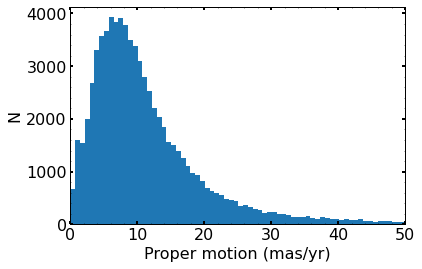

In [10]:
a,b,c=plt.hist(pm[~np.isnan(pm)],bins=1000)
plt.xlim(0,50)
plt.xlabel('Proper motion (mas/yr)')
plt.ylabel('N')
plt.show()

### Pick out objects with high proper motion (>15 mas/yr)

In [11]:
hpm = (~np.isnan(pm)) & (pm>15)

We'll plot a g-r,g CMD of the objects, and overplot those with high Gaia proper motions in red.  Note the Pal 5 main sequence found in NSC DR2, and that the high proper motion stars are all Galactic field stars.

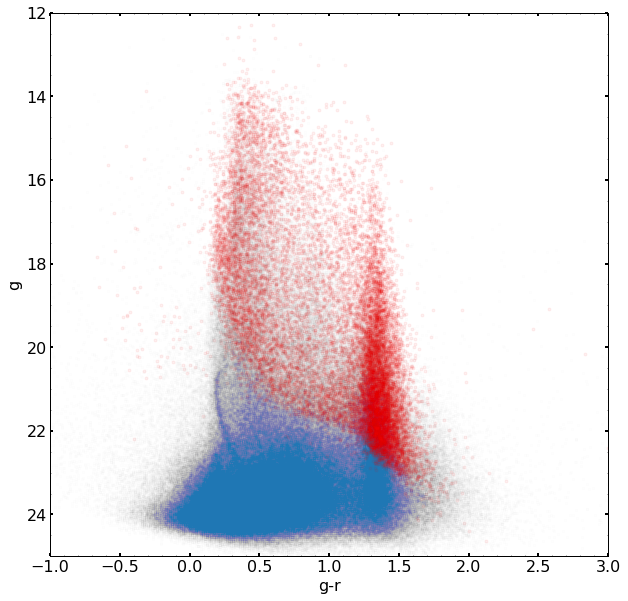

In [12]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(dfx['gmag']-dfx['rmag'],dfx['gmag'],marker='.',alpha=0.005)
ax1.scatter(dfx[hpm]['gmag']-dfx[hpm]['rmag'],dfx[hpm]['gmag'],marker='.',alpha=0.05,c='r')
ax1.set_xlim(-1,3)
ax1.set_ylim(25,12)
ax1.set_xlabel('g-r')
ax1.set_ylabel('g')
plt.show()

Let's make a 2D histogram of the CMD (a Hess diagram) so that we can see the Pal 5 sequence a bit more clearly.

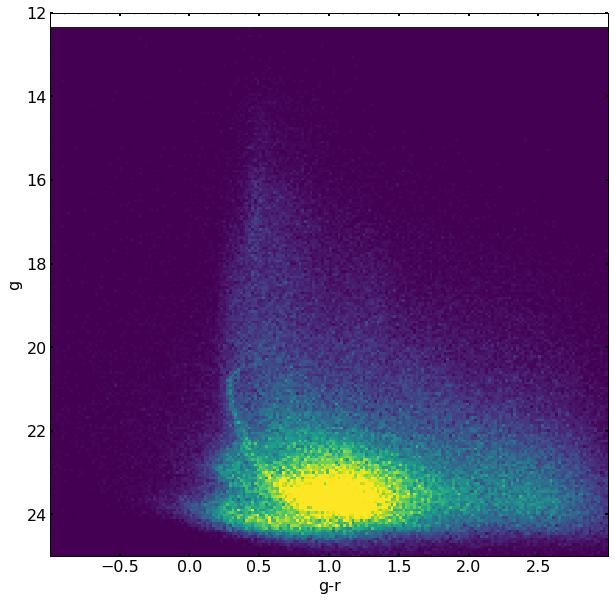

In [13]:
fig = plt.figure(figsize=(10,10))
x = dfx['gmag'] - dfx['imag']
y = dfx['gmag']
keep = (x>-1) & (x<3) & (y<25) & (y>12)
h2 = plt.hist2d(x[keep],y[keep],bins=200,vmin=0,vmax=75)
plt.ylim(25,12)
plt.xlabel('g-r')
plt.ylabel('g')
plt.show()

<a class="anchor" id="isolate"></a>
# Isolating Palomar 5
In order to focus on the Pal 5 stellar population, we'll make a color and magnitude cut of 0.25<g-r<0.5 and 20<gmag<23.

In [14]:
p5 = (x>0.25) & (x<0.5) & (y<23) & (y>20)

In [15]:
dfp = dfx[p5]

You can see a hint of the tidal tails in this filtered catalog.

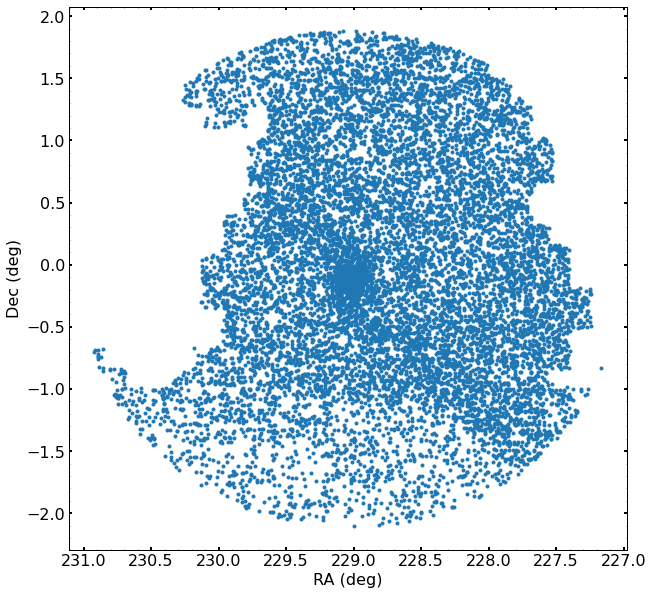

In [16]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(dfp['ra'],dfp['dec'],marker='.',alpha=1)
ax1.set_xlabel('RA (deg)')
ax1.set_ylabel('Dec (deg)')
plt.gca().invert_xaxis()
plt.show()

<a class="anchor" id="filter"></a>
# Spatial filtering
We'll see the tails more clearly if we apply a spatial filter, here the same Mexican hat filter that we used in the [Finding Dwarfs notebook](https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/DwarfGalaxies/DwarfGalaxiesInNscDr2.ipynb).  In the figure below, you can clearly see the S-shape of the cluster's tidal tails.

In [17]:
## a convolution filter
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    """Differential convolution with 2D Gaussian kernels.
    
       Based on Koposov et al. (2008).
       Code by Ken Mighell and Mike Fitzpatrick.
       Minor edits by RN.
       
       Parameters
       ----------
       ra, dec : float or array
           RA & Dec in degrees.
    
       fwhm_small, fwhm_big : float
           Full-width half maximum sizes of the small and big Gaussian kernels
           to use in convolution, in arcminutes.
    """
    
    x, y = ra, dec

    print("Computing differential convolution...")

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max()) / 2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint(xdiff_angular_arcmin).astype('int')
    ny = np.rint(ydiff_arcmin).astype('int')

    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve(raw_hist, kernel_big)
    conv_small = convolution.convolve(raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean(delta, dtype='float64')
    sigma = np.std(delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median(delta) # not used
    floor = mean

    clipped = delta.copy()
    clipped[delta < floor] = floor
    
    print("Done.")

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

In [18]:
raw_hist, extent, delta, clipped, sigma = \
    dwarf_filter(dfp['ra'],dfp['dec'],fwhm_small=8.0,fwhm_big=120)

Computing differential convolution...
Done.


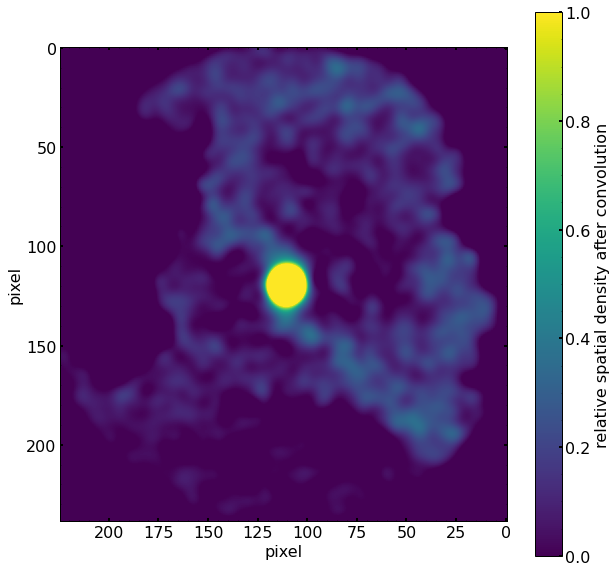

In [19]:
fig = plt.figure(figsize=(10,10))
im = plt.imshow(delta,vmin=0.0,vmax=1)
plt.gca().invert_xaxis()
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.colorbar(label='relative spatial density after convolution')
plt.show()

<a class="anchor" id="propermotions"></a>
# Exploring the proper motions
Gaia DR3 has proper motion measurements for some of the objects in our dataframe.  We'll use [matplotlib's quiver function](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html) to plot them.  In the plot below, you can tell that there is a bulk motion towards the center (around RA=229.0 and Dec=0.0), likely the reflex motion of the Sun.  Pal 5's proper motion is smaller than that of the foreground screen.

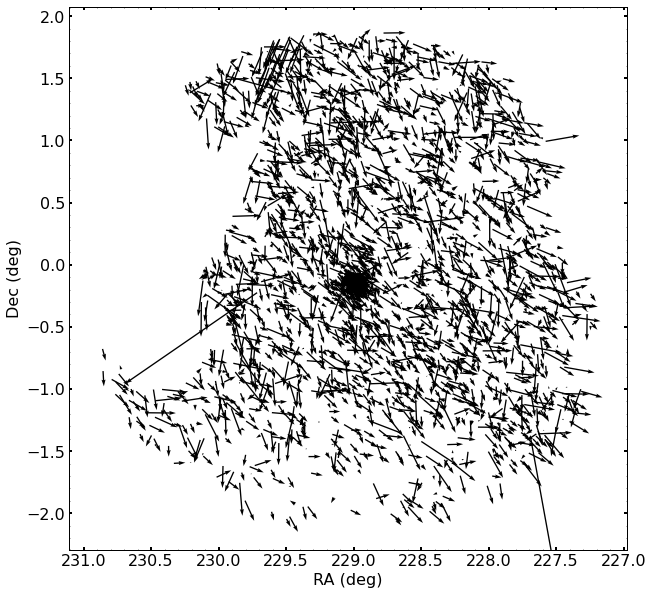

In [20]:
east_left = True
if east_left:
    flip = -1
else:
    flip = 1
x0 = dfp['ra']
y0 = dfp['dec']
dx = dfp['gaia_pmra']
dy = dfp['gaia_pmdec']

fig = plt.figure(figsize=(10,10))
plt.quiver(x0,y0,flip*dx,dy,scale_units='width',scale=200)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
if east_left: plt.gca().invert_xaxis()
plt.show()

If we limit the plot to those objects with smaller proper motions, Pal 5 and its tails are easier to see.

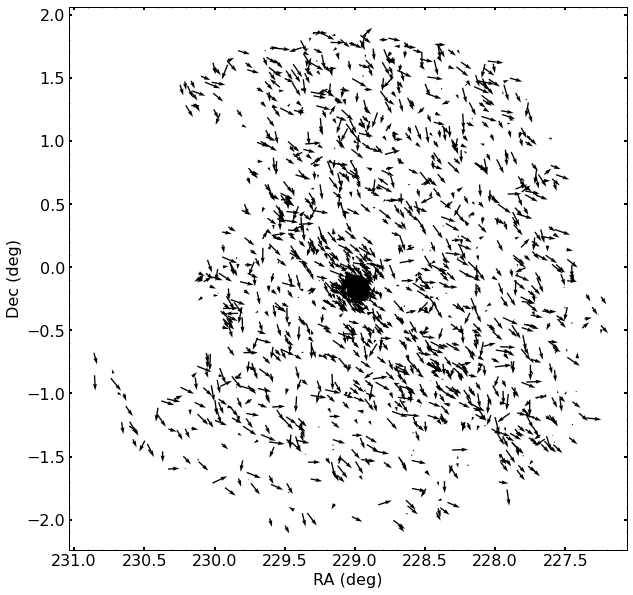

In [21]:
pm_limit = 6
pmp = np.sqrt(dfp['gaia_pmra']**2+dfp['gaia_pmdec']**2)
pmperr = np.sqrt(dfp['gaia_pmra_err']**2+dfp['gaia_pmdec_err']**2)
lpm = pmp<pm_limit
x0 = dfp[lpm]['ra']
y0 = dfp[lpm]['dec']
dx = dfp[lpm]['gaia_pmra']
dy = dfp[lpm]['gaia_pmdec']

fig = plt.figure(figsize=(10,10))
plt.quiver(x0,y0,flip*dx,dy,scale_units='width',scale=200)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
if east_left: plt.gca().invert_xaxis()
plt.show()

Let's take the mean Pal 5 proper motion and subtract it from our vectors, to view the proper motions in Pal 5's reference frame.  From the figure below, it looks like we might be able to cut out the proper motions a bit further to isolate Pal 5 and its tails.

In [22]:
core = (x0>228.9) & (x0<229.1) & (y0>-0.2) & (y0<0) # Pal 5 core
mpmra = np.mean(dx[core])
mpmdec = np.mean(dy[core])
dxp5 = dx - mpmra
dyp5 = dy - mpmdec
print(mpmra,mpmdec)

-2.489933011331422 -2.5776829536639236


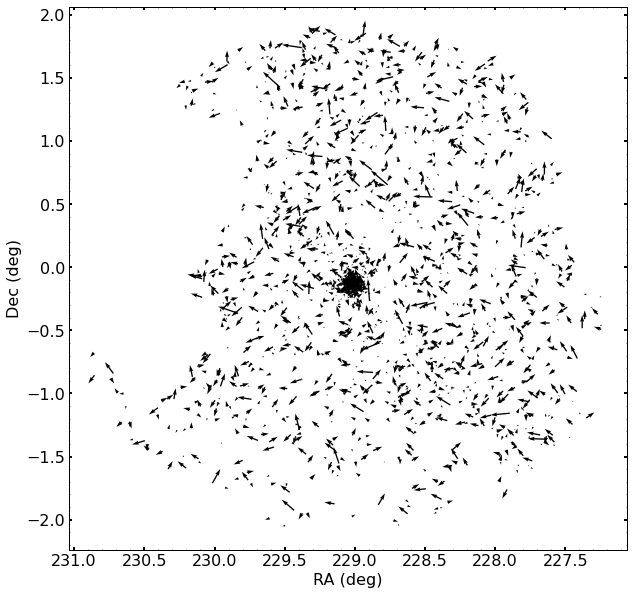

In [23]:
fig = plt.figure(figsize=(10,10))
plt.quiver(x0,y0,flip*dxp5,dyp5,scale_units='width',scale=200)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
if east_left: plt.gca().invert_xaxis()
plt.show()

In the figure below, we'll only show points that have proper motions close to those of Pal 5 within some limit.  It removes a bit more of the contamination.

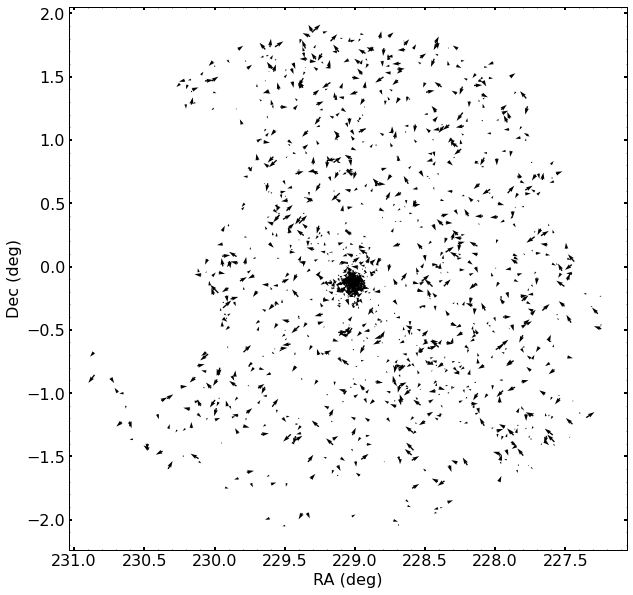

In [24]:
lim = 3. # try experimenting with this proper motion cut
p5 = (np.abs(dxp5)<lim)&(np.abs(dyp5)<lim)
fig = plt.figure(figsize=(10,10))
plt.quiver(x0[p5],y0[p5],flip*dxp5[p5],dyp5[p5],scale_units='width',scale=200)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
if east_left: plt.gca().invert_xaxis()
plt.show()

Let's see what happens when we apply our spatial filter to this proper motion-selected sample.  The northern tail clearly stands out.

In [25]:
rp5, ep5, dp5, cp5, sp5 = dwarf_filter(x0[p5],y0[p5],fwhm_small=8.0,fwhm_big=120)

Computing differential convolution...
Done.


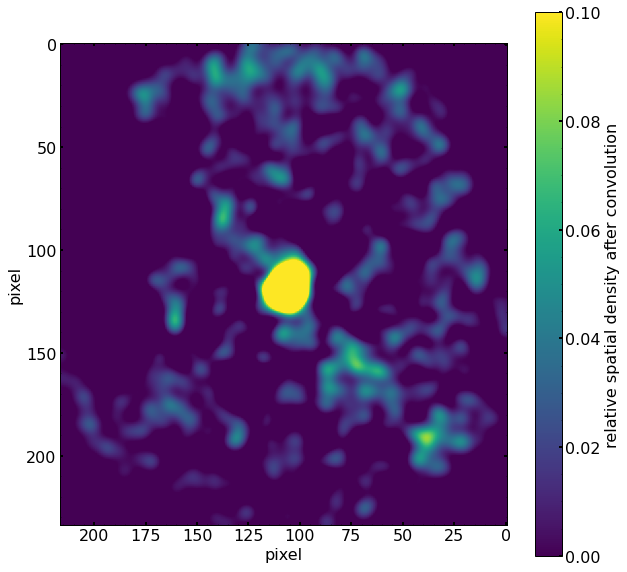

In [26]:
fig = plt.figure(figsize=(10,10))
im = plt.imshow(dp5,vmin=0.0,vmax=0.1)
plt.gca().invert_xaxis()
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.colorbar(label='relative spatial density after convolution')
plt.show()